<a href="https://colab.research.google.com/github/sabhapathi0306/DSS-for-cancer-exome-datasets/blob/main/method1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
data = pd.read_csv('DSS2.csv')
data['SIFT'].fillna(value = 'tolerated',inplace =True)

### SELECTING FEATURE and Data Preprocessing



*   **AS_SB_TABLE** Forward and reverse read counts for each allele, with alleles separated by the pipe character
• **DP** Approximate read depth
• **GERMQ**The phred-scaled posterior probability that the alternate allele(s) are not germline variants
**MBQ**Median base quality of each allele
*  **MMQ**Median mapping quality of each allele
• **MPOS** Median distance from the end of the read for each alternate allele
• **TLOD**Log odds that the variant is present in the tumor sample relative to the expected noise
•**POPAF** Population allele frequency of the alternate alleles

In [ ]:
x = data[['VARIANT_CLASS','TLOD','shiftscore', 'Sample.AF', 'SIFT','MBQ', 'MFRL', 'MMQ','Sample.AD', 'Sample.F1R2', 'Sample.F2R1', 'DP', 'GERMQ', 'MPOS',
       'POPAF', 'Sample.DP']]
a = {'SNV':0,'substitution':1,'deletion':2,'insertion':3}
x['VARIANT_CLASS'] = x['VARIANT_CLASS'].map(a)
b = {'deleterious':0, 'tolerated':1, 'deleterious_low_confidence':2,
       'tolerated_low_confidence':3}
x['SIFT'] = x['SIFT'].map(b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
x['cancer'] = data[['cancer']]
x.head(10)

,VARIANT_CLASS,TLOD,shiftscore,Sample.AF,SIFT,MBQ,MFRL,MMQ,Sample.AD,Sample.F1R2,Sample.F2R1,DP,GERMQ,MPOS,POPAF,Sample.DP,cancer
0,0,16.76,0.020000,0.412,0,37.32,195.196,60.60,9.60,3.40,6.20,15.0,23.0,17.0,7.30,15.0,High-grade serous ovarian cancer
1,0,51.22,0.670000,0.348,1,37.34,118.122,60.60,39.18,20.80,18.10,57.0,33.0,24.0,7.30,57.0,High-grade serous ovarian cancer
2,0,46.24,0.000000,0.518,0,37.31,151.103,60.60,14.17,11.70,3.10,32.0,24.0,22.0,7.30,31.0,High-grade serous ovarian cancer
3,1,121.71,0.168149,0.118,1,38.31,165.117,60.47,293.39,157.24,130.13,363.0,93.0,15.0,7.30,332.0,High-grade serous ovarian cancer
4,0,100.54,0.020000,0.962,0,0.38,0.159,60.60,0.25,0.12,0.13,25.0,27.0,12.0,3.02,25.0,High-grade serous ovarian cancer
5,0,246.01,0.210000,0.969,1,33.37,99.168,60.60,1.66,0.35,1.31,77.0,14.0,13.0,2.35,67.0,High-grade serous ovarian cancer
6,0,6.44,0.010000,0.274,0,36.30,140.151,60.60,14.70,6.40,8.00,26.0,24.0,24.0,7.30,21.0,High-grade serous ovarian cancer
7,0,197.85,0.400000,0.982,1,0.31,0.136,60.57,0.60,0.24,0.36,62.0,16.0,15.0,2.47,60.0,High-grade serous ovarian cancer
8,0,138.88,0.000000,0.974,0,0.34,0.132,60.60,0.39,0.21,0.16,41.0,25.0,18.0,2.93,39.0,High-grade serous ovarian cancer
9,0,130.30,0.000000,0.972,2,0.36,0.138,60.60,0.36,0.19,0.17,37.0,10.0,20.0,2.15,36.0,High-grade serous ovarian cancer


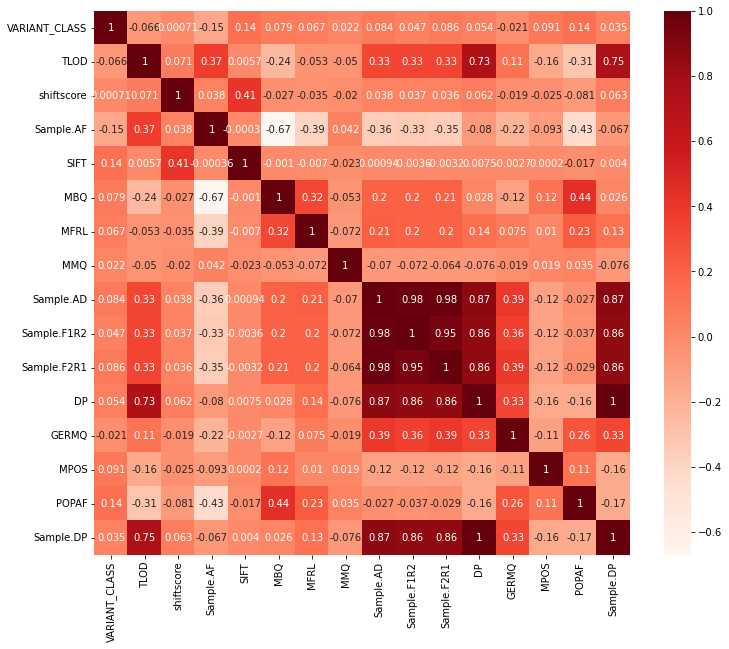

In [ ]:
## correlation heatmap
plt.figure(figsize=(12,10))
cor = x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

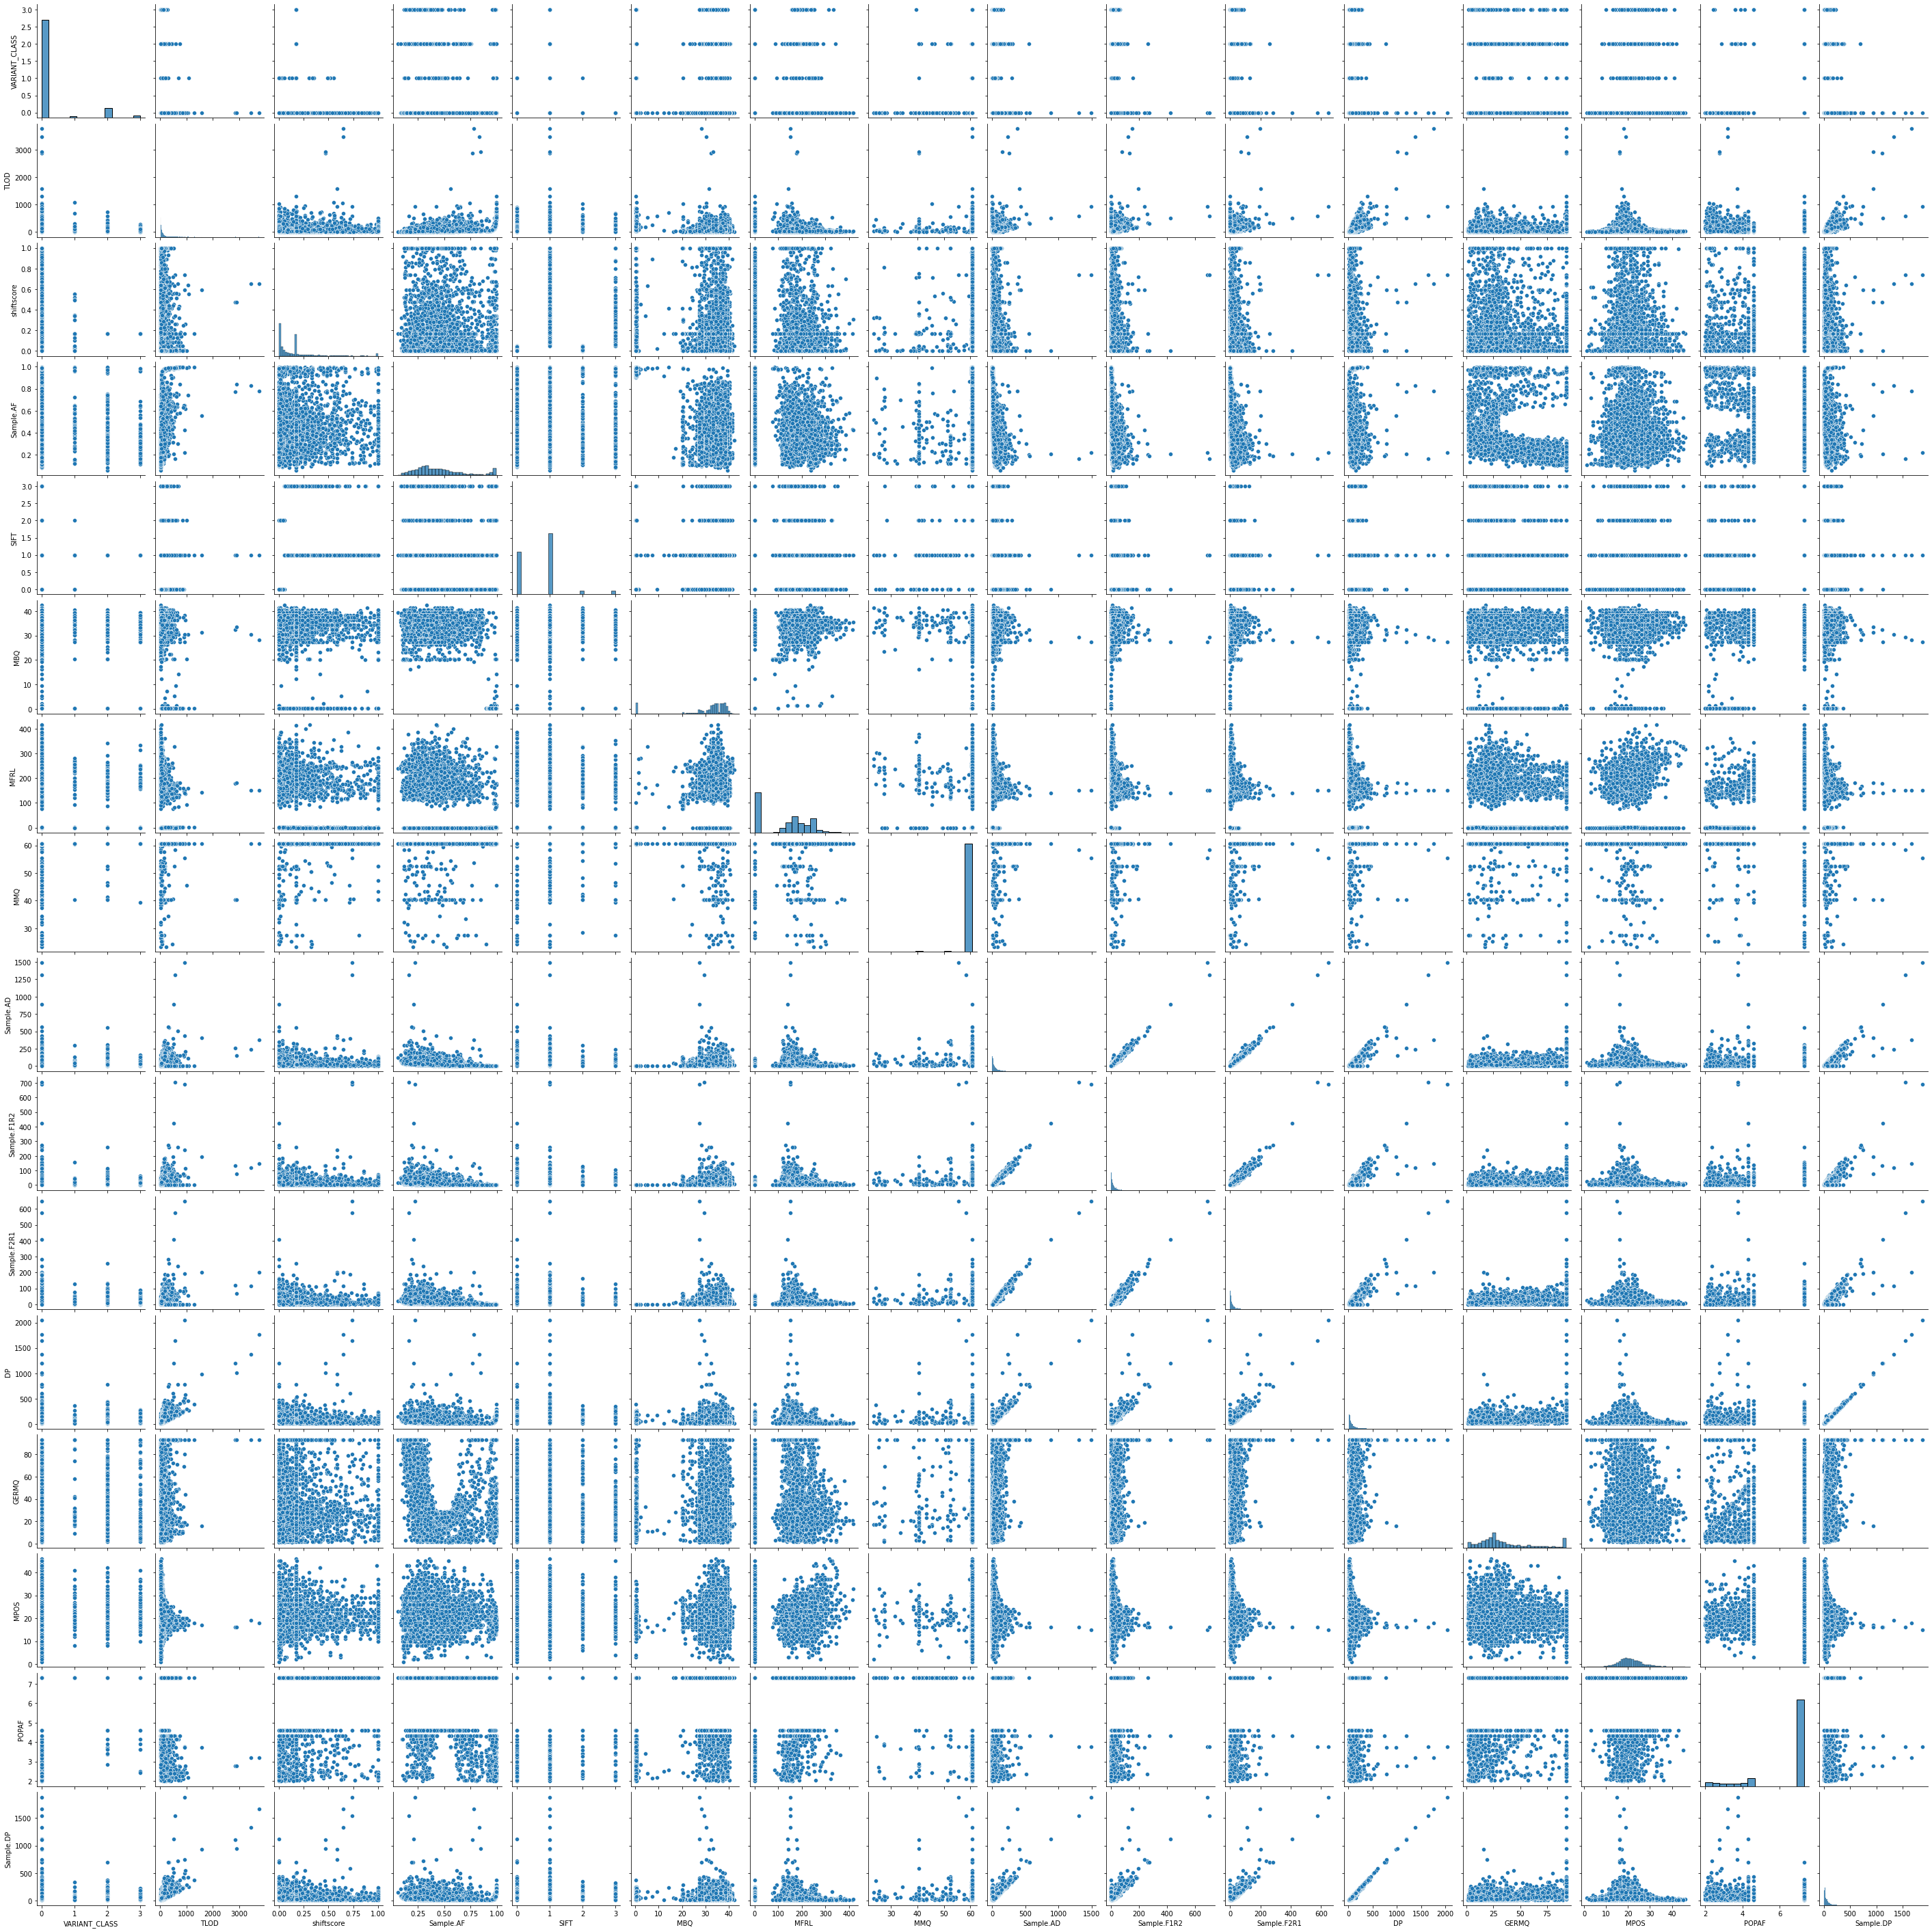

In [ ]:
sns.pairplot(x)

In [ ]:
# train_test and split
y = x[['cancer']] ## target
x = x.drop(['cancer'],axis = 1)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
x_train.shape,y_train.shape

((2926, 16), (2926, 1))

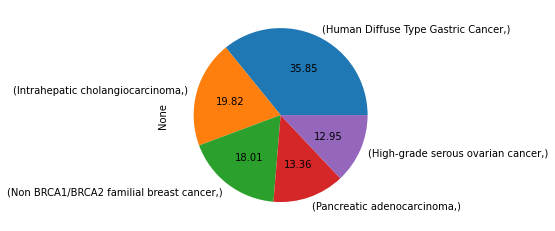

In [ ]:
y_train.value_counts().plot.pie(autopct='%.2f')

#### graph shows the our class of target is imbalnce and it is balanced using oversampling

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

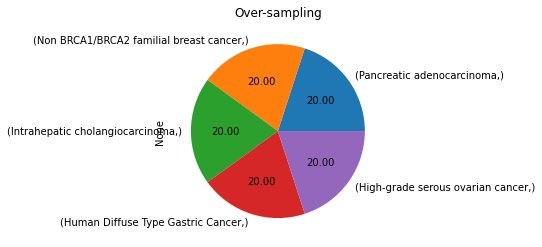

In [ ]:
## OVERSAMPLING
from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
y_train_ros = pd.DataFrame(y_train_ros)
ax = y_train_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [ ]:
# datasets after balanceing class
X_train_ros.shape, y_train_ros.shape

((5245, 16), (5245, 1))

### Random forest model for imbalanced data


In [ ]:
classifier= RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier.fit(x_train, y_train)
y_pred1 = classifier.predict(x_test)
print(classification_report(y_test, y_pred1))

                                        precision    recall  f1-score   support

      High-grade serous ovarian cancer       0.63      0.63      0.63       165
     Human Diffuse Type Gastric Cancer       0.84      0.88      0.86       455
       Intrahepatic cholangiocarcinoma       0.80      0.79      0.79       253
Non BRCA1/BRCA2 familial breast cancer       0.88      0.91      0.90       196
             Pancreatic adenocarcinoma       0.70      0.61      0.66       186

                              accuracy                           0.79      1255
                             macro avg       0.77      0.76      0.77      1255
                          weighted avg       0.79      0.79      0.79      1255



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


### Decision tree model for imbalance data


In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
y_pred = dtc.predict(x_test)
print(classification_report(y_test, y_pred))

                                        precision    recall  f1-score   support

      High-grade serous ovarian cancer       0.56      0.59      0.57       165
     Human Diffuse Type Gastric Cancer       0.79      0.79      0.79       455
       Intrahepatic cholangiocarcinoma       0.73      0.72      0.73       253
Non BRCA1/BRCA2 familial breast cancer       0.89      0.88      0.88       196
             Pancreatic adenocarcinoma       0.67      0.65      0.66       186

                              accuracy                           0.74      1255
                             macro avg       0.73      0.73      0.73      1255
                          weighted avg       0.74      0.74      0.74      1255



### Ramdom forest for balanced data

In [ ]:
classifier1= RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier1.fit(X_train_ros, y_train_ros)
y_pred1 = classifier1.predict(x_test)
print(classification_report(y_test, y_pred1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


                                        precision    recall  f1-score   support

      High-grade serous ovarian cancer       0.59      0.65      0.62       165
     Human Diffuse Type Gastric Cancer       0.86      0.83      0.85       455
       Intrahepatic cholangiocarcinoma       0.79      0.82      0.81       253
Non BRCA1/BRCA2 familial breast cancer       0.90      0.92      0.91       196
             Pancreatic adenocarcinoma       0.72      0.66      0.69       186

                              accuracy                           0.79      1255
                             macro avg       0.77      0.78      0.77      1255
                          weighted avg       0.80      0.79      0.80      1255



### model cross validtion for imbalance data

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(x_train,y_train)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, x_train, y_train, cv=5, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_test_pred
#mcc_train = matthews_corrcoef(X_train_ros, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

# Display model performance results
df_labels = pd.Series([ 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_cv, mcc_test], name = 'Performance_metric_values')
df3 = pd.concat([df_labels, df_values], axis=1)
df3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

,Performance_metric_names,Performance_metric_values
0,MCC_CV,0.776446
1,MCC_test,0.772359


### model cross validataion and test score for balanced data


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train_ros, y_train_ros)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train_ros, y_train_ros, cv=5, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train_ros)
y_test_pred = model.predict(x_test)
y_test_pred
#mcc_train = matthews_corrcoef(X_train_ros, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()

# Display model performance results
df_labels = pd.Series([ 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_cv, mcc_test], name = 'Performance_metric_values')
df3 = pd.concat([df_labels, df_values], axis=1)
df3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

,Performance_metric_names,Performance_metric_values
0,MCC_CV,0.936834
1,MCC_test,0.776557


## testing

In [ ]:
def testing(a):
  o = [a]
  x1 = data.loc[data['SampleID'].isin(o)] 
  test = x1[['VARIANT_CLASS','TLOD','shiftscore', 'Sample.AF', 'SIFT','MBQ', 'MFRL', 'MMQ','Sample.AD', 'Sample.F1R2', 'Sample.F2R1', 'DP', 'GERMQ', 'MPOS',
            'POPAF', 'Sample.DP']]
  a1 = {'SNV':0,'substitution':1,'deletion':2,'insertion':3}
  test['VARIANT_CLASS'] = test['VARIANT_CLASS'].map(a1)
  b1 = {'deleterious':0, 'tolerated':1, 'deleterious_low_confidence':2,
            'tolerated_low_confidence':3}
  test['SIFT'].fillna(value = 'tolerated',inplace =True)
  test['SIFT'] = test['SIFT'].map(b1)
  y_pp = clf.predict(test)
  y_pp = pd.DataFrame(y_pp)
  y_pp.value_counts().plot.pie(autopct='%.2f')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

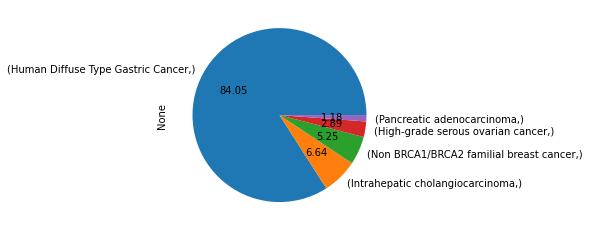

In [ ]:
a1 = 'SRR941054'
testing(a1) ## predicted cancer type

In [ ]:
o = ['SRR941054']
X = data.loc[data['SampleID'].isin(o)]
X['cancer'].head(2) ### actual cancer type 

3247    Human Diffuse Type Gastric Cancer
3248    Human Diffuse Type Gastric Cancer
Name: cancer, dtype: object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

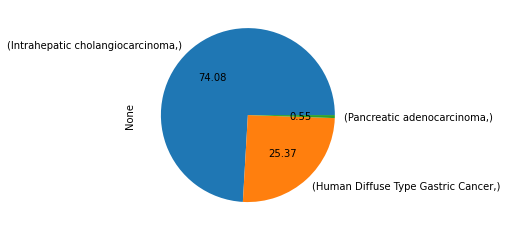

In [ ]:
a2 = 'SRR900123'
testing(a2)

In [ ]:
o = ['SRR900123']
X = data.loc[data['SampleID'].isin(o)]
X['cancer'].head(2) ### actual cancer type 

2133    Intrahepatic cholangiocarcinoma
2134    Intrahepatic cholangiocarcinoma
Name: cancer, dtype: object